# Red Inicial


## Imports


In [69]:
from __future__ import annotations

from itertools import product
from time import perf_counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from custom_env.actions import Acciones
from custom_env.router_env import RouterEnv
from gymnasium import make
from gymnasium.utils.env_checker import check_env
from pandas import DataFrame, Series
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.logger import Logger, configure
from stable_baselines3.common.monitor import Monitor

In [70]:
name = "Example"
tmp_path = "./train_log/"
env_id = "RouterEnv-v0"

progress_bar = True
if progress_bar:
    import rich
    import tqdm

## Clases y Funciones


In [71]:

"""

class PacketAttack(Enum):
    @staticmethod
    def new_set(description, weight, class_ref):
        return {
            "Description": description,
            "weight": weight,
            "class": class_ref
        }

    @staticmethod
    def not_implemented():
        raise NotImplementedError(f"Class not implemented")
    @classmethod
    @cache
    def weights(cls):
        attack_weights = []
        for attack in PacketAttack:
            attack_weights.append(attack.value["weight"])
        return np.array(attack_weights)

    # ----ENUM VALUES----
    DOS = new_set("Denial of Service", 1.0, DOS_Packet_Generator)
    DDOS = new_set("Distributed Denial of Service", 2.0, DDOS_Packet_Generator)


gen = DOS_Packet_Generator(step_dur=1e-6,seed=1)




print(len(gen.generate_packets()))

"""

'\n\nclass PacketAttack(Enum):\n    @staticmethod\n    def new_set(description, weight, class_ref):\n        return {\n            "Description": description,\n            "weight": weight,\n            "class": class_ref\n        }\n\n    @staticmethod\n    def not_implemented():\n        raise NotImplementedError(f"Class not implemented")\n    @classmethod\n    @cache\n    def weights(cls):\n        attack_weights = []\n        for attack in PacketAttack:\n            attack_weights.append(attack.value["weight"])\n        return np.array(attack_weights)\n\n    # ----ENUM VALUES----\n    DOS = new_set("Denial of Service", 1.0, DOS_Packet_Generator)\n    DDOS = new_set("Distributed Denial of Service", 2.0, DDOS_Packet_Generator)\n\n\ngen = DOS_Packet_Generator(step_dur=1e-6,seed=1)\n\n\n\n\nprint(len(gen.generate_packets()))\n\n'

In [72]:
tiempo_global: float = 0.0
iteraciones = 0
# Decaorador auxiliar para poder medir el tiempo de las funciones


def medir_tiempo(activado=False):
    def fun(funcion):
        def wrapper(*args, **kwargs):
            if not activado:
                return funcion(*args, **kwargs)
            fun_tiempo = perf_counter
            inicio: float = fun_tiempo()
            resultado = funcion(*args, **kwargs)
            tiempo_total: float = fun_tiempo() - inicio
            global tiempo_global, iteraciones
            medida = 1e6
            t: float = tiempo_total*medida
            tiempo_global += t
            iteraciones += 1
            print(f"Tiempo de ejecución de {
                funcion.__name__}: {t:.2f} micro-segundos")
            return resultado
        return wrapper
    return fun

## Entrenamiento


In [73]:

seed = None
env: RouterEnv = make(env_id, seed=seed)
# env = RouterEnv(seed=None)
check_env(env)

new_logger: Logger = configure(tmp_path, ["stdout", "csv"])
env = Monitor(env, tmp_path)


model: PPO = PPO("MlpPolicy", env,
                 verbose=True)


"""
eval_callback = EvalCallback(
    env,  # Entorno de evaluación
    best_model_save_path="./logs/best_model",  # Ruta para guardar el mejor modelo
    log_path="./logs",  # Ruta para guardar estadísticas
    eval_freq=10000,  # Frecuencia de evaluación (en pasos)
    deterministic=True,
    render=False,
)
, callback=eval_callback
"""
"""
ep_info = a.ep_info_buffer
print(a.ep_info_buffer)
if ep_info is not None and len(ep_info) > 0:
    rew=ep_info[0]["r"]
    print(rew)
    saved= PPO.load("Example")
    print(ep_info.pop())
"""


model.set_logger(new_logger)
try:
    model.learn(total_timesteps=int(1e5),
                progress_bar=progress_bar)
except KeyboardInterrupt:
    print("Entrenamiento interrumpido")


g: str = input("¿Desea guardarlo? (s/n) ")
if g.lower() == "s":
    model.save(name)
    print("Modelo guardado")

Logging to ./train_log/


Output()

Using cpu device
Wrapping the env in a DummyVecEnv.


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 400      |
|    ep_rew_mean     | 165      |
| time/              |          |
|    fps             | 656      |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 2048     |
---------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | 146         |
| time/                   |             |
|    fps                  | 570         |
|    iterations           | 2           |
|    time_elapsed         | 7           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.020481048 |
|    clip_fraction        | 0.388       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.677      |
|    explained_variance   | -0.00184    |
|    learning_rate        | 0.0003      |
|    loss                 | 2.13        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0448     |
|    value_loss           | 21.3        |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 114          |
| time/                   |              |
|    fps                  | 541          |
|    iterations           | 3            |
|    time_elapsed         | 11           |
|    total_timesteps      | 6144         |
| train/                  |              |
|    approx_kl            | 0.0006792914 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.671       |
|    explained_variance   | -0.0496      |
|    learning_rate        | 0.0003       |
|    loss                 | 18.9         |
|    n_updates            | 20           |
|    policy_gradient_loss | -0.00204     |
|    value_loss           | 126          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 107          |
| time/                   |              |
|    fps                  | 516          |
|    iterations           | 4            |
|    time_elapsed         | 15           |
|    total_timesteps      | 8192         |
| train/                  |              |
|    approx_kl            | 0.0031689403 |
|    clip_fraction        | 0.0206       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.674       |
|    explained_variance   | 0.602        |
|    learning_rate        | 0.0003       |
|    loss                 | 95.8         |
|    n_updates            | 30           |
|    policy_gradient_loss | -0.00488     |
|    value_loss           | 132          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 128          |
| time/                   |              |
|    fps                  | 514          |
|    iterations           | 5            |
|    time_elapsed         | 19           |
|    total_timesteps      | 10240        |
| train/                  |              |
|    approx_kl            | 0.0037088026 |
|    clip_fraction        | 0.0364       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.669       |
|    explained_variance   | 0.828        |
|    learning_rate        | 0.0003       |
|    loss                 | 45.8         |
|    n_updates            | 40           |
|    policy_gradient_loss | -0.0136      |
|    value_loss           | 105          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | 150         |
| time/                   |             |
|    fps                  | 516         |
|    iterations           | 6           |
|    time_elapsed         | 23          |
|    total_timesteps      | 12288       |
| train/                  |             |
|    approx_kl            | 0.012995908 |
|    clip_fraction        | 0.0294      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.652      |
|    explained_variance   | 0.857       |
|    learning_rate        | 0.0003      |
|    loss                 | 10.7        |
|    n_updates            | 50          |
|    policy_gradient_loss | -0.00492    |
|    value_loss           | 33.5        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | 164         |
| time/                   |             |
|    fps                  | 516         |
|    iterations           | 7           |
|    time_elapsed         | 27          |
|    total_timesteps      | 14336       |
| train/                  |             |
|    approx_kl            | 0.009929521 |
|    clip_fraction        | 0.0917      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.579      |
|    explained_variance   | 0.0396      |
|    learning_rate        | 0.0003      |
|    loss                 | 17.7        |
|    n_updates            | 60          |
|    policy_gradient_loss | -0.00905    |
|    value_loss           | 26.9        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | 167         |
| time/                   |             |
|    fps                  | 521         |
|    iterations           | 8           |
|    time_elapsed         | 31          |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.009041149 |
|    clip_fraction        | 0.13        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.633      |
|    explained_variance   | 0.733       |
|    learning_rate        | 0.0003      |
|    loss                 | 63.6        |
|    n_updates            | 70          |
|    policy_gradient_loss | -0.0233     |
|    value_loss           | 159         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 400        |
|    ep_rew_mean          | 193        |
| time/                   |            |
|    fps                  | 519        |
|    iterations           | 10         |
|    time_elapsed         | 39         |
|    total_timesteps      | 20480      |
| train/                  |            |
|    approx_kl            | 0.01962398 |
|    clip_fraction        | 0.0407     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.564     |
|    explained_variance   | -0.659     |
|    learning_rate        | 0.0003     |
|    loss                 | 38.5       |
|    n_updates            | 90         |
|    policy_gradient_loss | -0.00888   |
|    value_loss           | 113        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | 202         |
| time/                   |             |
|    fps                  | 519         |
|    iterations           | 11          |
|    time_elapsed         | 43          |
|    total_timesteps      | 22528       |
| train/                  |             |
|    approx_kl            | 0.011361882 |
|    clip_fraction        | 0.178       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.563      |
|    explained_variance   | 0.122       |
|    learning_rate        | 0.0003      |
|    loss                 | 18.6        |
|    n_updates            | 100         |
|    policy_gradient_loss | -0.00868    |
|    value_loss           | 39.2        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | 218         |
| time/                   |             |
|    fps                  | 520         |
|    iterations           | 12          |
|    time_elapsed         | 47          |
|    total_timesteps      | 24576       |
| train/                  |             |
|    approx_kl            | 0.007384499 |
|    clip_fraction        | 0.098       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.483      |
|    explained_variance   | 0.126       |
|    learning_rate        | 0.0003      |
|    loss                 | 47.6        |
|    n_updates            | 110         |
|    policy_gradient_loss | -0.00678    |
|    value_loss           | 48.2        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 400        |
|    ep_rew_mean          | 223        |
| time/                   |            |
|    fps                  | 521        |
|    iterations           | 13         |
|    time_elapsed         | 51         |
|    total_timesteps      | 26624      |
| train/                  |            |
|    approx_kl            | 0.01613269 |
|    clip_fraction        | 0.085      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.491     |
|    explained_variance   | -0.754     |
|    learning_rate        | 0.0003     |
|    loss                 | 64.6       |
|    n_updates            | 120        |
|    policy_gradient_loss | -0.0106    |
|    value_loss           | 185        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | 230         |
| time/                   |             |
|    fps                  | 521         |
|    iterations           | 14          |
|    time_elapsed         | 54          |
|    total_timesteps      | 28672       |
| train/                  |             |
|    approx_kl            | 0.007774596 |
|    clip_fraction        | 0.13        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.424      |
|    explained_variance   | 0.146       |
|    learning_rate        | 0.0003      |
|    loss                 | 20.1        |
|    n_updates            | 130         |
|    policy_gradient_loss | -0.00723    |
|    value_loss           | 59.4        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | 245         |
| time/                   |             |
|    fps                  | 523         |
|    iterations           | 15          |
|    time_elapsed         | 58          |
|    total_timesteps      | 30720       |
| train/                  |             |
|    approx_kl            | 0.004473198 |
|    clip_fraction        | 0.0451      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.381      |
|    explained_variance   | 0.048       |
|    learning_rate        | 0.0003      |
|    loss                 | 18.6        |
|    n_updates            | 140         |
|    policy_gradient_loss | -0.00402    |
|    value_loss           | 61.6        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | 251         |
| time/                   |             |
|    fps                  | 524         |
|    iterations           | 16          |
|    time_elapsed         | 62          |
|    total_timesteps      | 32768       |
| train/                  |             |
|    approx_kl            | 0.010189024 |
|    clip_fraction        | 0.0475      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.368      |
|    explained_variance   | -0.261      |
|    learning_rate        | 0.0003      |
|    loss                 | 142         |
|    n_updates            | 150         |
|    policy_gradient_loss | -0.00854    |
|    value_loss           | 272         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | 254         |
| time/                   |             |
|    fps                  | 523         |
|    iterations           | 17          |
|    time_elapsed         | 66          |
|    total_timesteps      | 34816       |
| train/                  |             |
|    approx_kl            | 0.005865064 |
|    clip_fraction        | 0.0772      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.395      |
|    explained_variance   | 0.0572      |
|    learning_rate        | 0.0003      |
|    loss                 | 37          |
|    n_updates            | 160         |
|    policy_gradient_loss | -0.00158    |
|    value_loss           | 73.1        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | 256         |
| time/                   |             |
|    fps                  | 526         |
|    iterations           | 18          |
|    time_elapsed         | 70          |
|    total_timesteps      | 36864       |
| train/                  |             |
|    approx_kl            | 0.001655044 |
|    clip_fraction        | 0.0162      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.447      |
|    explained_variance   | 0.121       |
|    learning_rate        | 0.0003      |
|    loss                 | 62.5        |
|    n_updates            | 170         |
|    policy_gradient_loss | -0.00049    |
|    value_loss           | 88.2        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | 259         |
| time/                   |             |
|    fps                  | 526         |
|    iterations           | 19          |
|    time_elapsed         | 73          |
|    total_timesteps      | 38912       |
| train/                  |             |
|    approx_kl            | 0.004348263 |
|    clip_fraction        | 0.0353      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.421      |
|    explained_variance   | 0.23        |
|    learning_rate        | 0.0003      |
|    loss                 | 30.7        |
|    n_updates            | 180         |
|    policy_gradient_loss | -0.000774   |
|    value_loss           | 73.4        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | 264         |
| time/                   |             |
|    fps                  | 525         |
|    iterations           | 20          |
|    time_elapsed         | 77          |
|    total_timesteps      | 40960       |
| train/                  |             |
|    approx_kl            | 0.005668321 |
|    clip_fraction        | 0.102       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.377      |
|    explained_variance   | 0.228       |
|    learning_rate        | 0.0003      |
|    loss                 | 19.1        |
|    n_updates            | 190         |
|    policy_gradient_loss | -0.00593    |
|    value_loss           | 76.4        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | 269         |
| time/                   |             |
|    fps                  | 525         |
|    iterations           | 21          |
|    time_elapsed         | 81          |
|    total_timesteps      | 43008       |
| train/                  |             |
|    approx_kl            | 0.008644128 |
|    clip_fraction        | 0.149       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.47       |
|    explained_variance   | 0.294       |
|    learning_rate        | 0.0003      |
|    loss                 | 61.3        |
|    n_updates            | 200         |
|    policy_gradient_loss | -0.0122     |
|    value_loss           | 123         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 288          |
| time/                   |              |
|    fps                  | 524          |
|    iterations           | 22           |
|    time_elapsed         | 85           |
|    total_timesteps      | 45056        |
| train/                  |              |
|    approx_kl            | 0.0011232524 |
|    clip_fraction        | 0.00103      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.493       |
|    explained_variance   | 0.167        |
|    learning_rate        | 0.0003       |
|    loss                 | 16.7         |
|    n_updates            | 210          |
|    policy_gradient_loss | 0.000236     |
|    value_loss           | 84.4         |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 292          |
| time/                   |              |
|    fps                  | 526          |
|    iterations           | 23           |
|    time_elapsed         | 89           |
|    total_timesteps      | 47104        |
| train/                  |              |
|    approx_kl            | 0.0068337796 |
|    clip_fraction        | 0.044        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.427       |
|    explained_variance   | 0.0965       |
|    learning_rate        | 0.0003       |
|    loss                 | 148          |
|    n_updates            | 220          |
|    policy_gradient_loss | -0.00368     |
|    value_loss           | 115          |
------------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 400        |
|    ep_rew_mean          | 311        |
| time/                   |            |
|    fps                  | 527        |
|    iterations           | 24         |
|    time_elapsed         | 93         |
|    total_timesteps      | 49152      |
| train/                  |            |
|    approx_kl            | 0.00525132 |
|    clip_fraction        | 0.0577     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.362     |
|    explained_variance   | 0.373      |
|    learning_rate        | 0.0003     |
|    loss                 | 48.4       |
|    n_updates            | 230        |
|    policy_gradient_loss | -0.00416   |
|    value_loss           | 92.8       |
----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 326          |
| time/                   |              |
|    fps                  | 526          |
|    iterations           | 25           |
|    time_elapsed         | 97           |
|    total_timesteps      | 51200        |
| train/                  |              |
|    approx_kl            | 0.0041344864 |
|    clip_fraction        | 0.0461       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.321       |
|    explained_variance   | -0.241       |
|    learning_rate        | 0.0003       |
|    loss                 | 212          |
|    n_updates            | 240          |
|    policy_gradient_loss | -0.00405     |
|    value_loss           | 295          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 330          |
| time/                   |              |
|    fps                  | 526          |
|    iterations           | 26           |
|    time_elapsed         | 101          |
|    total_timesteps      | 53248        |
| train/                  |              |
|    approx_kl            | 0.0051898174 |
|    clip_fraction        | 0.0396       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.33        |
|    explained_variance   | -0.171       |
|    learning_rate        | 0.0003       |
|    loss                 | 200          |
|    n_updates            | 250          |
|    policy_gradient_loss | -0.00564     |
|    value_loss           | 363          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 338          |
| time/                   |              |
|    fps                  | 525          |
|    iterations           | 27           |
|    time_elapsed         | 105          |
|    total_timesteps      | 55296        |
| train/                  |              |
|    approx_kl            | 0.0072717085 |
|    clip_fraction        | 0.0409       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.319       |
|    explained_variance   | 0.187        |
|    learning_rate        | 0.0003       |
|    loss                 | 30.2         |
|    n_updates            | 260          |
|    policy_gradient_loss | -0.0019      |
|    value_loss           | 90.5         |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | 338         |
| time/                   |             |
|    fps                  | 526         |
|    iterations           | 28          |
|    time_elapsed         | 108         |
|    total_timesteps      | 57344       |
| train/                  |             |
|    approx_kl            | 0.001141062 |
|    clip_fraction        | 0.0268      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.294      |
|    explained_variance   | 0.0972      |
|    learning_rate        | 0.0003      |
|    loss                 | 37.7        |
|    n_updates            | 270         |
|    policy_gradient_loss | -0.000231   |
|    value_loss           | 102         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 344          |
| time/                   |              |
|    fps                  | 527          |
|    iterations           | 29           |
|    time_elapsed         | 112          |
|    total_timesteps      | 59392        |
| train/                  |              |
|    approx_kl            | 0.0036848504 |
|    clip_fraction        | 0.0319       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.328       |
|    explained_variance   | 0.177        |
|    learning_rate        | 0.0003       |
|    loss                 | 131          |
|    n_updates            | 280          |
|    policy_gradient_loss | 0.000667     |
|    value_loss           | 124          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 347          |
| time/                   |              |
|    fps                  | 526          |
|    iterations           | 30           |
|    time_elapsed         | 116          |
|    total_timesteps      | 61440        |
| train/                  |              |
|    approx_kl            | 0.0039181607 |
|    clip_fraction        | 0.0235       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.272       |
|    explained_variance   | 0.145        |
|    learning_rate        | 0.0003       |
|    loss                 | 84.8         |
|    n_updates            | 290          |
|    policy_gradient_loss | -0.00215     |
|    value_loss           | 110          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 346          |
| time/                   |              |
|    fps                  | 526          |
|    iterations           | 31           |
|    time_elapsed         | 120          |
|    total_timesteps      | 63488        |
| train/                  |              |
|    approx_kl            | 0.0049245153 |
|    clip_fraction        | 0.0774       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.283       |
|    explained_variance   | 0.236        |
|    learning_rate        | 0.0003       |
|    loss                 | 35.3         |
|    n_updates            | 300          |
|    policy_gradient_loss | -0.00387     |
|    value_loss           | 96.5         |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 363          |
| time/                   |              |
|    fps                  | 527          |
|    iterations           | 32           |
|    time_elapsed         | 124          |
|    total_timesteps      | 65536        |
| train/                  |              |
|    approx_kl            | 0.0053422903 |
|    clip_fraction        | 0.107        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.38        |
|    explained_variance   | -0.0727      |
|    learning_rate        | 0.0003       |
|    loss                 | 99.1         |
|    n_updates            | 310          |
|    policy_gradient_loss | -0.00715     |
|    value_loss           | 188          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 372          |
| time/                   |              |
|    fps                  | 527          |
|    iterations           | 33           |
|    time_elapsed         | 128          |
|    total_timesteps      | 67584        |
| train/                  |              |
|    approx_kl            | 0.0068755792 |
|    clip_fraction        | 0.0866       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.262       |
|    explained_variance   | -0.0936      |
|    learning_rate        | 0.0003       |
|    loss                 | 425          |
|    n_updates            | 320          |
|    policy_gradient_loss | -0.0038      |
|    value_loss           | 560          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 386          |
| time/                   |              |
|    fps                  | 527          |
|    iterations           | 34           |
|    time_elapsed         | 132          |
|    total_timesteps      | 69632        |
| train/                  |              |
|    approx_kl            | 0.0015900834 |
|    clip_fraction        | 0.0084       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.289       |
|    explained_variance   | -0.0209      |
|    learning_rate        | 0.0003       |
|    loss                 | 365          |
|    n_updates            | 330          |
|    policy_gradient_loss | -0.000101    |
|    value_loss           | 611          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | 378         |
| time/                   |             |
|    fps                  | 526         |
|    iterations           | 35          |
|    time_elapsed         | 136         |
|    total_timesteps      | 71680       |
| train/                  |             |
|    approx_kl            | 0.001371091 |
|    clip_fraction        | 0.0127      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.248      |
|    explained_variance   | -0.0117     |
|    learning_rate        | 0.0003      |
|    loss                 | 388         |
|    n_updates            | 340         |
|    policy_gradient_loss | -0.000514   |
|    value_loss           | 815         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | 392         |
| time/                   |             |
|    fps                  | 525         |
|    iterations           | 36          |
|    time_elapsed         | 140         |
|    total_timesteps      | 73728       |
| train/                  |             |
|    approx_kl            | 0.008891273 |
|    clip_fraction        | 0.0476      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.272      |
|    explained_variance   | 0.00269     |
|    learning_rate        | 0.0003      |
|    loss                 | 28.9        |
|    n_updates            | 350         |
|    policy_gradient_loss | -0.00115    |
|    value_loss           | 139         |
-----------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 400           |
|    ep_rew_mean          | 402           |
| time/                   |               |
|    fps                  | 525           |
|    iterations           | 37            |
|    time_elapsed         | 144           |
|    total_timesteps      | 75776         |
| train/                  |               |
|    approx_kl            | 0.00070896884 |
|    clip_fraction        | 0.0249        |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.341        |
|    explained_variance   | -0.133        |
|    learning_rate        | 0.0003        |
|    loss                 | 229           |
|    n_updates            | 360           |
|    policy_gradient_loss | 0.00026       |
|    value_loss           | 776           |
-------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 400           |
|    ep_rew_mean          | 404           |
| time/                   |               |
|    fps                  | 526           |
|    iterations           | 38            |
|    time_elapsed         | 147           |
|    total_timesteps      | 77824         |
| train/                  |               |
|    approx_kl            | 0.00021592612 |
|    clip_fraction        | 0.0102        |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.272        |
|    explained_variance   | -0.00364      |
|    learning_rate        | 0.0003        |
|    loss                 | 134           |
|    n_updates            | 370           |
|    policy_gradient_loss | 0.000198      |
|    value_loss           | 580           |
-------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | 418         |
| time/                   |             |
|    fps                  | 526         |
|    iterations           | 39          |
|    time_elapsed         | 151         |
|    total_timesteps      | 79872       |
| train/                  |             |
|    approx_kl            | 0.005119456 |
|    clip_fraction        | 0.0418      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.223      |
|    explained_variance   | -0.0194     |
|    learning_rate        | 0.0003      |
|    loss                 | 24.6        |
|    n_updates            | 380         |
|    policy_gradient_loss | -0.000698   |
|    value_loss           | 147         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 427          |
| time/                   |              |
|    fps                  | 526          |
|    iterations           | 40           |
|    time_elapsed         | 155          |
|    total_timesteps      | 81920        |
| train/                  |              |
|    approx_kl            | 0.0017147919 |
|    clip_fraction        | 0.00352      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.209       |
|    explained_variance   | -0.0388      |
|    learning_rate        | 0.0003       |
|    loss                 | 391          |
|    n_updates            | 390          |
|    policy_gradient_loss | -2.23e-05    |
|    value_loss           | 502          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 429          |
| time/                   |              |
|    fps                  | 526          |
|    iterations           | 41           |
|    time_elapsed         | 159          |
|    total_timesteps      | 83968        |
| train/                  |              |
|    approx_kl            | 0.0006328351 |
|    clip_fraction        | 0.00469      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.326       |
|    explained_variance   | 0.0791       |
|    learning_rate        | 0.0003       |
|    loss                 | 265          |
|    n_updates            | 400          |
|    policy_gradient_loss | 4.35e-05     |
|    value_loss           | 423          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | 433         |
| time/                   |             |
|    fps                  | 526         |
|    iterations           | 42          |
|    time_elapsed         | 163         |
|    total_timesteps      | 86016       |
| train/                  |             |
|    approx_kl            | 0.004345253 |
|    clip_fraction        | 0.0513      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.293      |
|    explained_variance   | 0.0316      |
|    learning_rate        | 0.0003      |
|    loss                 | 65          |
|    n_updates            | 410         |
|    policy_gradient_loss | -0.0038     |
|    value_loss           | 161         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | 425         |
| time/                   |             |
|    fps                  | 525         |
|    iterations           | 43          |
|    time_elapsed         | 167         |
|    total_timesteps      | 88064       |
| train/                  |             |
|    approx_kl            | 0.003821856 |
|    clip_fraction        | 0.0426      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.233      |
|    explained_variance   | 0.00509     |
|    learning_rate        | 0.0003      |
|    loss                 | 147         |
|    n_updates            | 420         |
|    policy_gradient_loss | 0.000597    |
|    value_loss           | 176         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 437          |
| time/                   |              |
|    fps                  | 525          |
|    iterations           | 44           |
|    time_elapsed         | 171          |
|    total_timesteps      | 90112        |
| train/                  |              |
|    approx_kl            | 0.0047447807 |
|    clip_fraction        | 0.0368       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.384       |
|    explained_variance   | -0.0756      |
|    learning_rate        | 0.0003       |
|    loss                 | 110          |
|    n_updates            | 430          |
|    policy_gradient_loss | -0.00101     |
|    value_loss           | 166          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | 431         |
| time/                   |             |
|    fps                  | 525         |
|    iterations           | 45          |
|    time_elapsed         | 175         |
|    total_timesteps      | 92160       |
| train/                  |             |
|    approx_kl            | 0.007737194 |
|    clip_fraction        | 0.0664      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.266      |
|    explained_variance   | -0.0374     |
|    learning_rate        | 0.0003      |
|    loss                 | 432         |
|    n_updates            | 440         |
|    policy_gradient_loss | -0.00273    |
|    value_loss           | 714         |
-----------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 400           |
|    ep_rew_mean          | 429           |
| time/                   |               |
|    fps                  | 524           |
|    iterations           | 46            |
|    time_elapsed         | 179           |
|    total_timesteps      | 94208         |
| train/                  |               |
|    approx_kl            | 0.00041356322 |
|    clip_fraction        | 0.023         |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.195        |
|    explained_variance   | -0.0495       |
|    learning_rate        | 0.0003        |
|    loss                 | 32.4          |
|    n_updates            | 450           |
|    policy_gradient_loss | -0.00172      |
|    value_loss           | 143           |
-------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | 430         |
| time/                   |             |
|    fps                  | 523         |
|    iterations           | 47          |
|    time_elapsed         | 183         |
|    total_timesteps      | 96256       |
| train/                  |             |
|    approx_kl            | 0.008481541 |
|    clip_fraction        | 0.0725      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.35       |
|    explained_variance   | -0.00114    |
|    learning_rate        | 0.0003      |
|    loss                 | 95.1        |
|    n_updates            | 460         |
|    policy_gradient_loss | -0.00209    |
|    value_loss           | 138         |
-----------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 400           |
|    ep_rew_mean          | 430           |
| time/                   |               |
|    fps                  | 523           |
|    iterations           | 48            |
|    time_elapsed         | 187           |
|    total_timesteps      | 98304         |
| train/                  |               |
|    approx_kl            | 0.00069424487 |
|    clip_fraction        | 0.016         |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.239        |
|    explained_variance   | 0.0784        |
|    learning_rate        | 0.0003        |
|    loss                 | 23.2          |
|    n_updates            | 470           |
|    policy_gradient_loss | 0.000105      |
|    value_loss           | 161           |
-------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 432          |
| time/                   |              |
|    fps                  | 522          |
|    iterations           | 49           |
|    time_elapsed         | 192          |
|    total_timesteps      | 100352       |
| train/                  |              |
|    approx_kl            | 0.0011715782 |
|    clip_fraction        | 0.0355       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.302       |
|    explained_variance   | 0.112        |
|    learning_rate        | 0.0003       |
|    loss                 | 36.2         |
|    n_updates            | 480          |
|    policy_gradient_loss | -0.00231     |
|    value_loss           | 136          |
------------------------------------------


Modelo guardado


### Gráficas de Entrenamiento


['time/time_elapsed', 'time/total_timesteps', 'time/fps', 'time/iterations', 'rollout/ep_rew_mean', 'rollout/ep_len_mean', 'train/approx_kl', 'train/loss', 'train/entropy_loss', 'train/value_loss', 'train/explained_variance', 'train/policy_gradient_loss', 'train/n_updates', 'train/learning_rate', 'train/clip_fraction', 'train/clip_range']


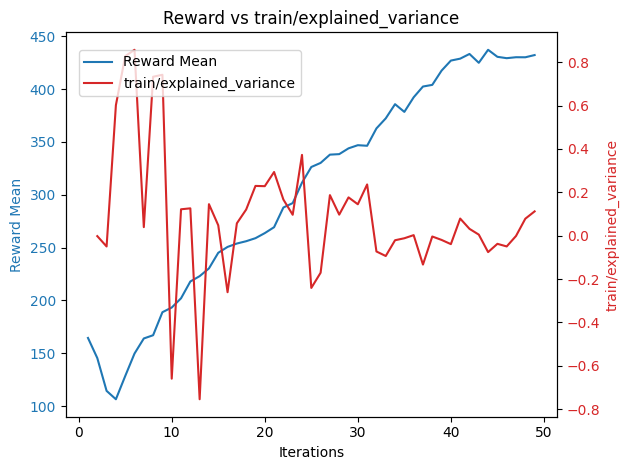

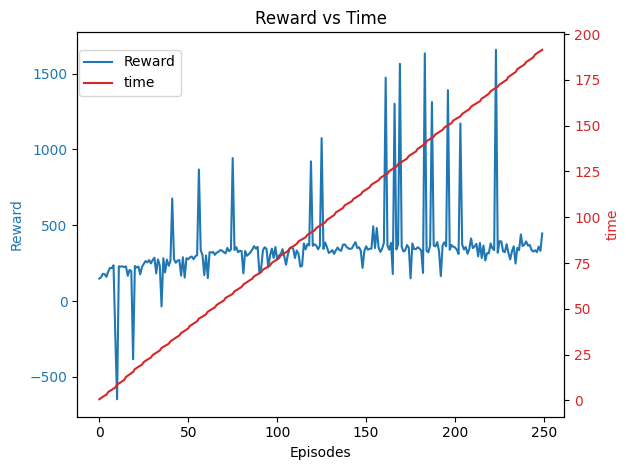

In [74]:
train_data_log: DataFrame = pd.read_csv(tmp_path+"progress.csv")
train_data_monitor: DataFrame = pd.read_csv(tmp_path+"monitor.csv", header=1)

# train_data_monitor = pd.concat([train_data_monitor] * 3, ignore_index=True)
print(train_data_log.columns.to_list())

fig, ax1 = plt.subplots()

iterations: Series[int] = train_data_log['time/iterations'].astype(int)


ax1.set_xlabel('Iterations')
color = 'tab:blue'
ax1.set_ylabel('Reward Mean', color=color)
ax1.plot(iterations,
         train_data_log['rollout/ep_rew_mean'], color=color, label='Reward Mean')
ax1.tick_params(axis='y', labelcolor=color)


col = 'train/explained_variance'

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel(col, color=color)
ax2.plot(iterations, train_data_log[col], color=color, label=col)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_title('Reward vs ' + col)


fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.12, 0.9))

plt.show()


fig, ax1 = plt.subplots()

episodes = range(len(train_data_monitor['l']))

# Plot rollout/ep_rew_mean on the first y-axis
ax1.set_xlabel('Episodes')
color = 'tab:blue'
ax1.set_ylabel('Reward', color=color)
ax1.plot(episodes, train_data_monitor['r'], color=color, label='Reward')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_title('Reward vs Time')


ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('time', color=color)
ax2.plot(episodes, train_data_monitor['t'], color=color, label='time')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.12, 0.9))

plt.show()

## Comprobación funcionamiento


In [75]:
seed = None
env = make(env_id, seed=seed)
model = PPO.load(name, print_system_info=True)
print(type(env))
num_steps = 1
obs, _ = env.reset()
# Variables de información:
acciones = []
rewards = []
ocu = []
tams = []
num = []
lim_ocu = 0
a2 = []

# -------------------------

_states = None
ant = env._get_info()
for episode in range(num_steps):

    done = False
    step_counter = 0
    while not done:
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, terminated, info = env.step(action)
        if len(ant) > 0 and ant != info:
            print(info["Stats"])
        ant = info

        ocu.append(info["Stats"]["OcupacionActual"])
        lim_ocu = info["Stats"]["LimiteOcupación"]
        tams.append(info["Stats"]["TamañoTotal"])
        num.append(info["Stats"]["NumPaquetes"])
        a2.append(info["Stats"]["Action"])

        rewards.append(reward)
        acciones.append(action.item())

        done: bool = done or terminated

    env.reset(seed=seed)
    step_counter += 1

# Debug
print(f"Acciones: {acciones}")
print(list(map(lambda x: Acciones.int_to_action(x), acciones)))
print(list(map(lambda x: int(round(x, 0)), rewards)))
print(a2)

== CURRENT SYSTEM INFO ==
- OS: Windows-10-10.0.19045-SP0 10.0.19045
- Python: 3.12.6
- Stable-Baselines3: 2.4.1
- PyTorch: 2.5.1+cpu
- GPU Enabled: False
- Numpy: 1.26.4
- Cloudpickle: 3.1.0
- Gymnasium: 1.0.0

== SAVED MODEL SYSTEM INFO ==
- OS: Windows-10-10.0.19045-SP0 10.0.19045
- Python: 3.12.6
- Stable-Baselines3: 2.4.1
- PyTorch: 2.5.1+cpu
- GPU Enabled: False
- Numpy: 1.26.4
- Cloudpickle: 3.1.0
- Gymnasium: 1.0.0

<class 'custom_env.router_env.RouterEnv'>
{'EstadoMaquina': 'EstadoAtaque', 'NumPaquetes': 0, 'TamañoTotal': 0.0, 'Action': <Acciones.PERMITIR: 1>, 'OcupacionActual': 0.0, 'LimiteOcupación': 0.8}
{'EstadoMaquina': 'EstadoAtaque', 'NumPaquetes': 4, 'TamañoTotal': 413.0, 'Action': <Acciones.PERMITIR: 1>, 'OcupacionActual': 0.016, 'LimiteOcupación': 0.8}
{'EstadoMaquina': 'EstadoNormal', 'NumPaquetes': 9, 'TamañoTotal': 911.0, 'Action': <Acciones.PERMITIR: 1>, 'OcupacionActual': 0.036, 'LimiteOcupación': 0.8}
{'EstadoMaquina': 'EstadoNormal', 'NumPaquetes': 3, 'TamañoT

In [76]:
assert len(acciones) != a2.count(Acciones.DENEGAR)
assert len(acciones) != a2.count(Acciones.PERMITIR)

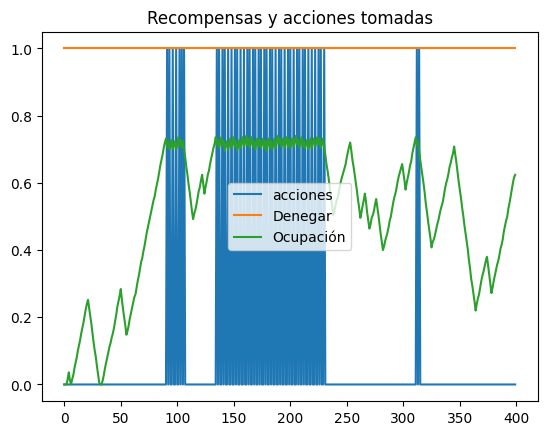

Rewards:  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -0.1, 1.0, -0.1, 1.0, 1.0, -0.1, 1.0, 1.0, -0.1, 1.0, 1.0, -0.1, 1.0, -0.1, 1.0, -0.1, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -0.1, 1.0, -0.1, 1.0, 1.0, -0.1, 1.0, -0.1, 1.0, 1.0, -0.1, 1.0, 1.0, -0.1, 1.0, 1.0, -0.1, 1.0, -0.1, 1.0, 1.0, -0.1, 1.0, 1.0, -0.1, 1.0, 1.0, -0.1, 1.0, -0.1, 1.0, 1.0, -0.1, 1.0, -0.1, 1.0, 1.0, -0.1, 1.0, -0.1, 1.0, 1.0, -0.1, 1.0, -0.1, 1.0, 1.0, -0.1, 1.0, -0.1, 1.0, 1.0, -0.1, 1.0, 1.0, -0.1, 1.0, 

In [77]:
assert len(acciones) == len(rewards)
# plt.plot(rewards, label="rewards")
plt.plot(acciones, label="acciones")

plt.plot([Acciones.action_to_int(Acciones.DENEGAR)]
         * len(acciones), label="Denegar")
plt.plot(ocu, label="Ocupación")
plt.title("Recompensas y acciones tomadas")

plt.legend()
plt.show()
print("Rewards: ", rewards)
num_permitidos = acciones.count(Acciones.action_to_int(Acciones.PERMITIR))
print(num_permitidos, len(acciones)-num_permitidos, "",
      num_permitidos/len(acciones), 1-num_permitidos/len(acciones))

Ocupación:  [0.0, 0.0, 0.0, 0.016, 0.036, 0.012, 0.0, 0.016, 0.028, 0.048, 0.064, 0.08, 0.1, 0.116, 0.132, 0.152, 0.168, 0.184, 0.204, 0.224, 0.24, 0.252, 0.228, 0.204, 0.18, 0.152, 0.124, 0.1, 0.08, 0.052, 0.028, 0.004, 0.0, 0.0, 0.012, 0.028, 0.048, 0.064, 0.08, 0.096, 0.112, 0.124, 0.14, 0.152, 0.168, 0.188, 0.208, 0.232, 0.248, 0.264, 0.284, 0.252, 0.224, 0.2, 0.176, 0.148, 0.16, 0.176, 0.196, 0.212, 0.228, 0.244, 0.26, 0.268, 0.288, 0.308, 0.324, 0.344, 0.364, 0.376, 0.396, 0.412, 0.432, 0.452, 0.468, 0.484, 0.5, 0.516, 0.532, 0.548, 0.56, 0.58, 0.596, 0.612, 0.632, 0.652, 0.668, 0.684, 0.704, 0.72, 0.732, 0.708, 0.724, 0.7, 0.712, 0.728, 0.7, 0.712, 0.724, 0.7, 0.712, 0.736, 0.712, 0.728, 0.704, 0.724, 0.7, 0.676, 0.648, 0.624, 0.596, 0.572, 0.544, 0.516, 0.492, 0.508, 0.52, 0.536, 0.556, 0.576, 0.588, 0.608, 0.624, 0.596, 0.568, 0.588, 0.604, 0.624, 0.636, 0.656, 0.672, 0.688, 0.704, 0.716, 0.736, 0.712, 0.728, 0.704, 0.72, 0.736, 0.712, 0.724, 0.696, 0.712, 0.724, 0.7, 0.716, 0

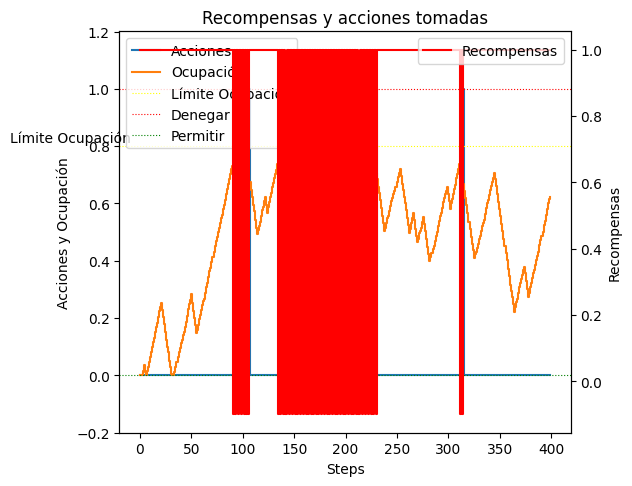

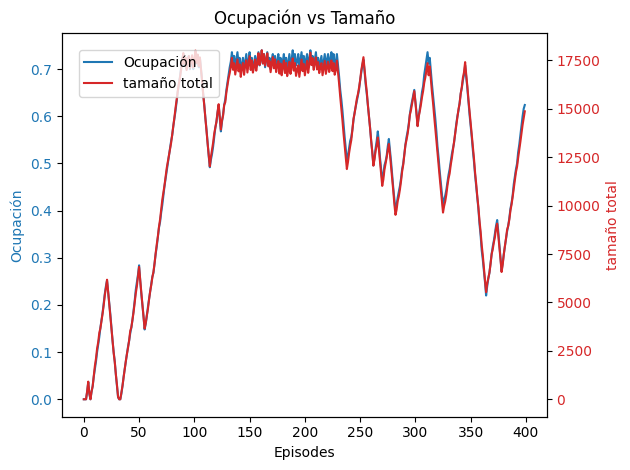

La ocupación máxima es de 74%
La ocupación mínima es de 0%


In [78]:
print("Ocupación: ", ocu)
fig, ax1 = plt.subplots()

# Configurar el eje X e Y
ax1.set_xlabel('Steps')
ax1.set_ylabel('Acciones y Ocupación')

# Graficar las acciones y la ocupación
ax1.step(range(len(acciones)), acciones, label="Acciones", where='post')
# ax1.step(range(len(acciones)), [1] * len(acciones), label="Denegar", where='mid')  # Ajustar según tus datos
ax1.step(range(len(ocu)), ocu, label="Ocupación", where='mid')

# Crear línea horizontal en el gráfico
ax1.axhline(y=lim_ocu, color='yellow', linestyle='dotted',
            linewidth=0.8, label='Límite Ocupación')

# Agregar marca en el eje Y
ticks = list(ax1.get_yticks())  # Obtener los ticks actuales
if lim_ocu not in ticks:
    ticks.append(lim_ocu)  # Agregar el límite de ocupación a los ticks
ax1.set_yticks(sorted(ticks))  # Actualizar los ticks

# Anotar el límite en el eje
ax1.annotate(
    'Límite Ocupación',
    xy=(-0.1, lim_ocu),  # Coordenada en el eje Y
    xytext=(-50, lim_ocu + 5),
    textcoords='offset points',
    fontsize=10, color='black',
    ha='center',
    va='center'
)
ax1.axhline(y=Acciones.action_to_int(Acciones.DENEGAR), color='red',
            linestyle='dotted', linewidth=0.8, label='Denegar')
ax1.axhline(y=Acciones.action_to_int(Acciones.PERMITIR),
            color='green', linestyle='dotted', linewidth=0.8, label='Permitir')


# Leyenda del primer eje
ax1.legend(loc='upper left')

# Crear segundo eje Y para las recompensas
ax2 = ax1.twinx()
ax2.set_ylabel('Recompensas')
ax2.step(range(len(rewards)), rewards,
         label="Recompensas", where='mid', color='r')

# Leyenda del segundo eje
ax2.legend(loc='upper right')

# Ajustar diseño y mostrar título
fig.tight_layout()
plt.title("Recompensas y acciones tomadas")
plt.show()


tam = [x/1 for x in tams]


"""
plt.step(range(len(acciones)), acciones, label="acciones", where='mid')
plt.step(range(len(acciones)), [Acciones.action_to_int(Acciones.DENEGAR)]*len(acciones), label="Denegar", where='mid')
plt.plot([lim_ocu]*len(ocu), label="LimiteOcupación")
"""

fig, ax1 = plt.subplots()

episodes = range(len(train_data_monitor['l']))

# Plot rollout/ep_rew_mean on the first y-axis
ax1.set_xlabel('Episodes')
color = 'tab:blue'
label = 'Ocupación'
ax1.set_ylabel(label, color=color)
ax1.plot(range(len(ocu)), ocu, color=color, label=label)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_title('Ocupación vs Tamaño')


ax2 = ax1.twinx()
color = 'tab:red'
label = 'tamaño total'
ax2.set_ylabel(label, color=color)
ax2.plot(range(len(tams)), tam, color=color, label=label)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.12, 0.9))

plt.show()

"""plt.step(range(len(ocu)),ocu, label="Ocupación",where='mid')
plt.step(range(len(tams)),tam, label="Tamaño",where='mid')


plt.title("Recompensas y acciones tomadas")
plt.legend()
plt.show()"""
print(f"La ocupación máxima es de {np.max(ocu):.0%}")
print(f"La ocupación mínima es de {np.min(ocu):.0%}")

## Pruebas:


In [79]:
print(f"Tiempo medio: {tiempo_global/iteraciones if abs(iteraciones) > 1e-5 else 0:.2f} micro-segundos de {iteraciones} iteraciones")

Tiempo medio: 0.00 micro-segundos de 0 iteraciones


In [80]:
print(Acciones.action_to_int(Acciones.PERMITIR))
print(Acciones.action_to_int(Acciones.DENEGAR))

0
1


['EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'Estado

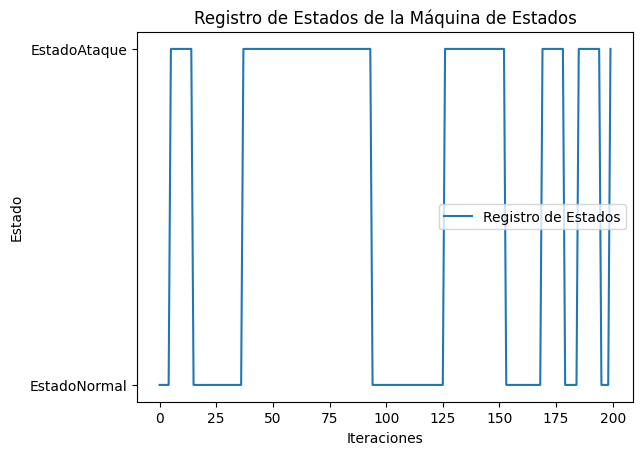

In [81]:
from custom_env.states import *
maquina = MaquinaDeEstados()
for _ in range(200):
    maquina.cambiar_estado()
print(maquina.registro_estados)

plt.plot(maquina.registro_estados, label="Registro de Estados")
plt.xlabel("Iteraciones")
plt.ylabel("Estado")
plt.title("Registro de Estados de la Máquina de Estados")
plt.legend()
plt.show()

In [82]:
# Lista de ejemplo
lista: list[str] = [x.__name__ for x in maquina.estados_posibles]
combinaciones_con_repeticion = list(product(lista, repeat=2))
dict_con: dict[tuple[str, str], int] = {
    x: 0 for x in combinaciones_con_repeticion}

print(dict_con)
duracion_ataques = []
estado_Ant = maquina.registro_estados[0]

for estado in maquina.registro_estados[1:]:
    dict_con[(estado_Ant, estado)] += 1

    if (estado_Ant, estado) == (EstadoNormal.__name__, EstadoAtaque.__name__):  # Empieza ataque
        duracion_ataques.append(1)
    elif (estado_Ant, estado) == (EstadoAtaque.__name__, EstadoAtaque.__name__):  # Sigue ataque
        if len(duracion_ataques) > 0:
            duracion_ataques[-1] += 1

    estado_Ant: Estado = estado

print(
    f"Como promedio los {len(duracion_ataques)} ataques duran {np.mean(duracion_ataques):.1f} iteraciones.")
print("Duracion 5 primeros ataques: ", duracion_ataques[:5], "...")
try:
    for estado1 in lista:
        total = 0
        for estado2 in lista:
            total += dict_con[(estado1, estado2)]
        print(f"Estando en {estado1}:")
        for estado2 in lista:
            print(f"De {estado1} a {estado2}: {
                dict_con[(estado1, estado2)] / total:6.2%}")
except:
    pass

{('EstadoNormal', 'EstadoNormal'): 0, ('EstadoNormal', 'EstadoAtaque'): 0, ('EstadoAtaque', 'EstadoNormal'): 0, ('EstadoAtaque', 'EstadoAtaque'): 0}
Como promedio los 6 ataques duran 19.2 iteraciones.
Duracion 5 primeros ataques:  [10, 57, 27, 10, 10] ...
Estando en EstadoNormal:
De EstadoNormal a EstadoNormal: 92.94%
De EstadoNormal a EstadoAtaque:  7.06%
Estando en EstadoAtaque:
De EstadoAtaque a EstadoNormal:  4.39%
De EstadoAtaque a EstadoAtaque: 95.61%


In [83]:
_np_random, _ = seeding.np_random(None)
pak = []
for _ in range(1000):
    pak.append(_np_random.integers(1, 10, endpoint=True))

print(f"{np.min(pak)},{np.max(pak)},{np.mean(pak):.0f},{np.std(pak):.0f}")
pak = []
for _ in range(1000):
    pak.append(_np_random.integers(1, 10, endpoint=False))

print(f"{np.min(pak)},{np.max(pak)},{np.mean(pak):.0f},{np.std(pak):.0f}")
print(type(0.0), type(0))
print(int(0.2))

1,10,6,3
1,9,5,3
<class 'float'> <class 'int'>
0
